Hugging Face

In [58]:
# All imports 

from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
import transformers
from huggingface_hub import login,notebook_login
from transformers import DataCollatorForTokenClassification
from transformers import AutoTokenizer
import evaluate
from datasets import Dataset
import numpy as np
import os
from transformers import pipeline
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
# Log into hugging face
notebook_login()

In [3]:
# All pip installed packages


#%pip install ipywidgets
"""
%pip install accelerate -U
%pip install transformers
%pip install datasets
%pip install seqeval
#pip install transformers datasets evaluate seqeval
"""

'\n%pip install accelerate -U\n%pip install transformers\n%pip install datasets\n%pip install seqeval\n'

In [4]:
label_list = ['O', 'B-LOC', 'I-LOC', 'B-PER', 'B-ORG', 'I-ORG', 'I-PER']


label2id = {
    'O': 0,
    'B-LOC': 1,
    'I-LOC': 2,
    'B-PER': 3,
    'B-ORG': 4,
    'I-ORG': 5,
    'I-PER': 6
}

id2label = {
    0: 'O',
    1: 'B-LOC',
    2: 'I-LOC',
    3: 'B-PER',
    4: 'B-ORG',
    5: 'I-ORG',
    6: 'I-PER'
    }

In [5]:
#label_to_index['O']

## 1. Proccessing the  EWT data

In [6]:
# Open the data and create dictionaries for each sentence 

def parse_iob2_content(content):
    data = []
    sentence_id = None
    sen_id = 0
    for line in content.split('\n'):
        line = line.strip()
        if line.startswith('# sent_id ='):
            temp_dic = {}
            #sentence_id = line.split('=')[1].strip()
            sentence_id = sen_id
            sen_id+= 1
            temp_dic['id'] = sentence_id
            temp_dic['tokens'] = []
            temp_dic['ner_tags'] = []
        elif line and not line.startswith('#'):
            parts = line.split('\t')
            temp_dic['tokens'].append(parts[1])
            temp_dic['ner_tags'].append(label2id[parts[2]])
        elif not line:
            data.append(temp_dic)
    return data

# Parse training data
with open('en_ewt-ud-train.iob2', 'r', encoding='utf-8') as file:
    content_train = file.read()



# Parse development data
with open('en_ewt-ud-dev.iob2', 'r', encoding='utf-8') as file:
    content_dev = file.read()

# Parse test data
#with open('en_ewt-ud-test-masked.iob2', 'r', encoding='utf-8') as file:
 #   content_test = file.read()

train_data = parse_iob2_content(content_train)
dev_data = parse_iob2_content(content_dev)
#test_data = parse_iob2_content(content_test)

train_data

[{'id': 0,
  'tokens': ['Where', 'in', 'the', 'world', 'is', 'Iguazu', '?'],
  'ner_tags': [0, 0, 0, 0, 0, 1, 0]},
 {'id': 1, 'tokens': ['Iguazu', 'Falls'], 'ner_tags': [1, 2]},
 {'id': 2,
  'tokens': ['Widely',
   'considered',
   'to',
   'be',
   'one',
   'of',
   'the',
   'most',
   'spectacular',
   'waterfalls',
   'in',
   'the',
   'world',
   ',',
   'the',
   'Iguazu',
   'Falls',
   'on',
   'the',
   'border',
   'of',
   'Argentina',
   'and',
   'Brazil',
   ',',
   'are',
   'a',
   'certainly',
   'must',
   'see',
   'attraction',
   'in',
   'the',
   'area',
   '.'],
  'ner_tags': [0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   2,
   0,
   0,
   0,
   0,
   1,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0]},
 {'id': 3,
  'tokens': ['The',
   'centre',
   'of',
   'the',
   'falls',
   'is',
   'known',
   'locally',
   'as',
   '‘',
   'Garganta',
   'Del',
   'Diablo',
   '’',
   '(',


In [7]:
# Get the number of sentances 
def count_unique_ids(data):
    unique_ids = set()
    for item in data:
        unique_ids.add(item['id'])
    return len(unique_ids)

numb_sentances = count_unique_ids(dev_data)
numb_sentances 

2001

In [8]:
# Stuff from the hugging face


tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-cased")
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
seqeval = evaluate.load("seqeval")
os.environ["WANDB_DISABLED"] = "true"

In [9]:
#example = train_data[0]

def tokenize_and_align_labels(example):
    tokenized_inputs = tokenizer(example["tokens"], truncation=True, is_split_into_words=True)
    #print(tokenized_inputs)
    #print(example['ner_tags'])
    #labels_ = []
    for i, label in enumerate(example[f"ner_tags"]):
        #print(i, label)
        word_ids = tokenized_inputs.word_ids()  # Map tokens to their respective word.
        #print(word_ids)
        #print('Hi')
        #print(word_ids, "Hi")
        #print(label)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
                #print(label_ids)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                #print(label[word_idx])
                #print(label)
                #print(example[f"ner_tags"][word_idx])
                label_ids.append(example["ner_tags"][word_idx])
                #label_ids.append(label[word_idx])
                #label_ids.append(label)
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        #labels_.append(label_ids)
        #print(labels_)

    tokenized_inputs["labels"] = label_ids #labels_
    #print('Hi')
    return tokenized_inputs

In [10]:
# Tokenize both datsets EWT (dev and train)
tokeized_train = []
for i in train_data:
    t = tokenize_and_align_labels(i)
    tokeized_train.append(t)

#print(tokeized_train)
#tokenized_inputs


tokeized_dev = []
for i in dev_data:
    t = tokenize_and_align_labels(i)
    tokeized_dev.append(t)

In [45]:
#example_ids =

#labels = [label_list[i] for i in example[f"ner_tags"]]


def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

## 2. Process TweeBank data 

In [12]:
def process_bio_file(file_path):
    label2id = {
        'O': 0,
        'B-LOC': 1,
        'I-LOC': 2,
        'B-PER': 3,
        'B-ORG': 4,
        'I-ORG': 5,
        'I-PER': 6
    }

    compare_data = []

    with open(file_path, 'r', encoding='utf-8') as file:
        sentences = []
        current_sentence = {'id': 0, 'tokens': [], 'ner_tags': []}
        sentence_id = 0  # Initialize sentence ID

        for line in file:
            # Skip lines starting with '-DOCSTART-' or empty lines
            if line.startswith("-DOCSTART-") or line.strip() == "":
                # If the current sentence is not empty, append it to the list of sentences
                if current_sentence['tokens']:
                    sentences.append(current_sentence)
                    current_sentence = {'id': sentence_id, 'tokens': [], 'ner_tags': []}  # Reset current sentence
                    sentence_id += 1  # Increment sentence ID
                continue
            
            # Split the line into word and label
            word, _, _, label = line.strip().split('\t')
            
            # Append word to the current sentence tokens
            current_sentence['tokens'].append(word)
            # Map label to its corresponding numerical value using label2id dictionary
            current_sentence['ner_tags'].append(label2id.get(label, 0))  # Use 0 as default if label is not found

        # Append the last sentence to the list of sentences if it's not empty
        if current_sentence['tokens']:
            sentences.append(current_sentence)

        compare_data.extend(sentences)
    
    return compare_data

# Call the function with the file path
compare_data_1 = process_bio_file('train.bio')

# Print the processed data
print(compare_data_1)

[{'id': 0, 'tokens': ['RT', '@USER2362', ':', 'Farmall', 'Heart', 'Of', 'The', 'Holidays', 'Tabletop', 'Christmas', 'Tree', 'With', 'Lights', 'And', 'Motion', 'URL1087', '#Holiday', '#Gifts'], 'ner_tags': [0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}, {'id': 0, 'tokens': ['#Volunteers', 'are', 'key', 'members', 'of', '#CHEO’s', 'One', 'Team', '–', 'helping', 'kids', 'and', 'families', 'be', 'their', 'healthiest', '#NVW2016', 'URL1387'], 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}, {'id': 1, 'tokens': ['@USER2092', 'is', "n't", 'it', 'funny', 'how', 'that', 'always', 'seems', 'to', 'work'], 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}, {'id': 2, 'tokens': ['RT', '@USER80', ':', 'Silence', 'is', 'better', 'than', 'lies', '.'], 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 0]}, {'id': 3, 'tokens': ['I', 'just', 'spent', 'twenty', 'minutes', 'trying', 'to', 'figure', 'out', 'how', 'my', 'sister', "'s", 'TV', 'works', '...'], 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 0

In [13]:
def process_bio_file(file_path):
    label2id = {
        'O': 0,
        'B-LOC': 1,
        'I-LOC': 2,
        'B-PER': 3,
        'B-ORG': 4,
        'I-ORG': 5,
        'I-PER': 6
    }

    compare_data = []

    with open(file_path, 'r', encoding='utf-8') as file:
        sentences = []
        current_sentence = {'id': 0, 'tokens': [], 'ner_tags': []}
        sentence_id = 0  # Initialize sentence ID

        for line in file:
            # Skip lines starting with '-DOCSTART-' or empty lines
            if line.startswith("-DOCSTART-") or line.strip() == "":
                # If the current sentence is not empty, append it to the list of sentences
                if current_sentence['tokens']:
                    sentences.append(current_sentence)
                    current_sentence = {'id': sentence_id, 'tokens': [], 'ner_tags': []}  # Reset current sentence
                    sentence_id += 1  # Increment sentence ID
                continue
            
            # Split the line into word and label
            word, _, _, label = line.strip().split('\t')
            
            # Append word to the current sentence tokens
            current_sentence['tokens'].append(word)
            # Map label to its corresponding numerical value using label2id dictionary
            current_sentence['ner_tags'].append(label2id.get(label, 0))  # Use 0 as default if label is not found

        # Append the last sentence to the list of sentences if it's not empty
        if current_sentence['tokens']:
            sentences.append(current_sentence)

        compare_data.extend(sentences)
    
    return compare_data

# Call the function with the file path
compare_data_1 = process_bio_file('train.bio')

# Print the processed data
print(compare_data_1)


[{'id': 0, 'tokens': ['RT', '@USER2362', ':', 'Farmall', 'Heart', 'Of', 'The', 'Holidays', 'Tabletop', 'Christmas', 'Tree', 'With', 'Lights', 'And', 'Motion', 'URL1087', '#Holiday', '#Gifts'], 'ner_tags': [0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}, {'id': 0, 'tokens': ['#Volunteers', 'are', 'key', 'members', 'of', '#CHEO’s', 'One', 'Team', '–', 'helping', 'kids', 'and', 'families', 'be', 'their', 'healthiest', '#NVW2016', 'URL1387'], 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}, {'id': 1, 'tokens': ['@USER2092', 'is', "n't", 'it', 'funny', 'how', 'that', 'always', 'seems', 'to', 'work'], 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}, {'id': 2, 'tokens': ['RT', '@USER80', ':', 'Silence', 'is', 'better', 'than', 'lies', '.'], 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 0]}, {'id': 3, 'tokens': ['I', 'just', 'spent', 'twenty', 'minutes', 'trying', 'to', 'figure', 'out', 'how', 'my', 'sister', "'s", 'TV', 'works', '...'], 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 0

In [14]:

# Tokenize the comparison data
tokeized_comparedata_1 = []
for i in compare_data_1 :
    t = tokenize_and_align_labels(i)
    tokeized_comparedata_1.append(t)

print(tokeized_comparedata_1[:10])
#tokenized_inputs


[{'input_ids': [101, 155, 1942, 137, 1646, 9637, 22737, 1545, 1477, 131, 6865, 5727, 4641, 2096, 1109, 10450, 1116, 11389, 9870, 3394, 8659, 1556, 13951, 1262, 12153, 158, 20550, 10424, 1604, 1559, 108, 10450, 108, 22889, 1116, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [-100, 0, -100, 0, -100, -100, -100, -100, -100, 0, 4, -100, 0, 0, 0, 0, -100, 0, -100, 0, 0, 0, 0, 0, 0, 0, -100, -100, -100, -100, 0, -100, 0, -100, -100, -100]}, {'input_ids': [101, 108, 19340, 1132, 2501, 1484, 1104, 108, 24890, 2036, 2346, 787, 188, 1448, 2649, 782, 4395, 4067, 1105, 2073, 1129, 1147, 2332, 9102, 108, 151, 2559, 2924, 10973, 16229, 158, 20550, 17668, 1604, 1559, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [-100, 0, -100, 0, 0, 0, 0, 0, -100, -100, -100, -100, -100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100, 

## 3. Process the crossNER dataset

In [15]:
label2id_crossNER = {
    'O': 0,
    'B-location': 1,
    'I-location': 2,
    'B-person': 3,
    'B-organisation': 4,
    'I-organisation': 5,
    'I-person': 6,
    'B-misc': 0,
    'I-misc': 0
}

In [16]:


def parse_iob2_content_crossNER(content):
    data = []
    sen_id = 0
    temp_dic = {}
    temp_dic['id'] = sen_id
    temp_dic['tokens'] = []
    temp_dic['ner_tags'] = []
    prev_line = 'start' #added
    for line in content.split('\n'):
        
        line = line.strip()
        if line == '' and prev_line != '': #if line is empty and the previous line wasn't empty as well
            
            data.append(temp_dic)
            temp_dic = {}
            sen_id+= 1
            temp_dic['id'] = sen_id
            temp_dic['tokens'] = []
            temp_dic['ner_tags'] = []
        elif line:
            parts = line.split('\t')
            temp_dic['tokens'].append(parts[0])
            temp_dic['ner_tags'].append(label2id_crossNER[parts[1]])
        prev_line = line #added
    return data

In [17]:
# Parse training data
with open('crossNER_train.txt', 'r', encoding='utf-8') as file:
    content_crossNER_train = file.read()

In [44]:
crossNER_train_data = parse_iob2_content_crossNER(content_crossNER_train)
crossNER_train_data

tokeized_train_crossNER = []
for i in crossNER_train_data:
    #print(i)
    t = tokenize_and_align_labels(i)
    tokeized_train_crossNER.append(t)

#tokeized_train_crossNER

## 4. Count the number of tokens,sentances and lables 

In [19]:
def count_tokens(data):
    total_tokens = 0
    for item in data:
        total_tokens += len(item['input_ids'])
    return total_tokens
# count the number of tokens per each dataset
nmb_tokens_crossNER = count_tokens (tokeized_train_crossNER)
nmb_tokens_tweet = count_tokens(tokeized_comparedata_1)
nmb_tokens_ewt = count_tokens(tokeized_dev)


In [20]:
def count_items(dataset):
    return len(dataset)

# Get the number of sentances for all the datasets
numb_sentances_crossNER = count_items(tokeized_train_crossNER)
numb_sentances_tweet = count_items(tokeized_comparedata_1)
numb_sentances_ewt = count_items(tokeized_dev)
print(numb_sentances_crossNER,numb_sentances_tweet,numb_sentances_ewt)

14041 1639 2002


In [21]:
def count_labels(data):
    label_counts = {
        'O': 0,
        'B-LOC': 0,
        'I-LOC': 0,
        'B-PER': 0,
        'B-ORG': 0,
        'I-ORG': 0,
        'I-PER': 0
    }

    for item in data:
        ner_tags = item['ner_tags']
        for tag in ner_tags:
            for label, index in label2id.items():
                if index == tag:
                    label_counts[label] += 1

    return label_counts

# Call the function with the processed data
label_counts = count_labels(compare_data_1)
label_counts_dev = count_labels(dev_data)
label_counts_crossNER = count_labels(crossNER_train_data)

# Print the counts
print("Label Counts:")
for label, count in label_counts.items():
    print(label, ":", count)



# Print the counts
print("Label Counts:")
for label, count in label_counts_dev.items():
    print(label, ":", count)


# Print the counts
print("Label Counts:")
for label, count in label_counts_crossNER.items():
    print(label, ":", count)



Label Counts:
O : 23731
B-LOC : 136
I-LOC : 35
B-PER : 360
B-ORG : 245
I-ORG : 102
I-PER : 144
Label Counts:
O : 23678
B-LOC : 399
I-LOC : 148
B-PER : 343
B-ORG : 224
I-ORG : 186
I-PER : 196
Label Counts:
O : 174171
B-LOC : 7129
I-LOC : 1168
B-PER : 6600
B-ORG : 6297
I-ORG : 3728
I-PER : 4528


In [22]:
#tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-cased")

In [23]:
#example = train_data[0]
"""
tokenized_input = tokenizer(example["tokens"], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
tokens
"""

'\ntokenized_input = tokenizer(example["tokens"], is_split_into_words=True)\ntokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])\ntokens\n'

In [24]:
'''def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        #print('Hi')
        #print(word_ids, "Hi")
        #print(label)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                #print(label[word_idx])
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs'''

'def tokenize_and_align_labels(examples):\n    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)\n\n    labels = []\n    for i, label in enumerate(examples[f"ner_tags"]):\n        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.\n        #print(\'Hi\')\n        #print(word_ids, "Hi")\n        #print(label)\n        previous_word_idx = None\n        label_ids = []\n        for word_idx in word_ids:  # Set the special tokens to -100.\n            if word_idx is None:\n                label_ids.append(-100)\n            elif word_idx != previous_word_idx:  # Only label the first token of a given word.\n                #print(label[word_idx])\n                label_ids.append(label[word_idx])\n            else:\n                label_ids.append(-100)\n            previous_word_idx = word_idx\n        labels.append(label_ids)\n\n    tokenized_inputs["labels"] = labels\n    return tokenized_inputs'

In [25]:
#train_data[:2]

In [27]:
#from datasets import load_dataset

## The Model 

In [28]:


model = AutoModelForTokenClassification.from_pretrained(
    "distilbert/distilbert-base-cased", num_labels=7, id2label=id2label, label2id=label2id
)

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert/distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
# Train the model

"""
training_args = TrainingArguments(
    output_dir="our_awesome_BERT_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    #push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokeized_train,
    eval_dataset=tokeized_dev,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

model_output = trainer.train()
"""

#trainer.predict()

'\ntraining_args = TrainingArguments(\n    output_dir="our_awesome_BERT_model",\n    learning_rate=2e-5,\n    per_device_train_batch_size=16,\n    per_device_eval_batch_size=16,\n    num_train_epochs=2,\n    weight_decay=0.01,\n    evaluation_strategy="epoch",\n    save_strategy="epoch",\n    load_best_model_at_end=True,\n    #push_to_hub=True,\n)\n\ntrainer = Trainer(\n    model=model,\n    args=training_args,\n    train_dataset=tokeized_train,\n    eval_dataset=tokeized_dev,\n    tokenizer=tokenizer,\n    data_collator=data_collator,\n    compute_metrics=compute_metrics,\n)\n\nmodel_output = trainer.train()\n'

In [31]:
#trainer

In [32]:
# push the model to the hugging face website
#trainer.push_to_hub("model_name1")

In [33]:
# Save the mdoel locally
#model_output
#trainer.save_model("model1")

In [34]:
#text = "The Golden State Warriors are an American professional basketball team based in San Francisco."

In [35]:



classifier = pipeline("ner", model="our_awesome_BERT_model/checkpoint-784/")
classifier(text)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[{'entity': 'B-LOC',
  'score': 0.54000354,
  'index': 2,
  'word': 'Golden',
  'start': 4,
  'end': 10},
 {'entity': 'I-LOC',
  'score': 0.73839927,
  'index': 3,
  'word': 'State',
  'start': 11,
  'end': 16},
 {'entity': 'I-ORG',
  'score': 0.5714838,
  'index': 4,
  'word': 'Warriors',
  'start': 17,
  'end': 25},
 {'entity': 'B-LOC',
  'score': 0.9762792,
  'index': 13,
  'word': 'San',
  'start': 80,
  'end': 83},
 {'entity': 'I-LOC',
  'score': 0.98662853,
  'index': 14,
  'word': 'Francisco',
  'start': 84,
  'end': 93}]

In [36]:
# read the txt file
#f = open("train.txt", "r")
#print(f.read())

## Test the model on 3 datasets

In [46]:
# Load the model
loaded_model = AutoModelForTokenClassification.from_pretrained("model1")
trainer = Trainer(model = loaded_model)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
c:\Users\45911\AppData\Local\Programs\Python\Python311\Lib\site-packages\accelerate\accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [47]:
collated_compare_data=data_collator(tokeized_comparedata_1)

In [48]:
test_dataset= Dataset.from_dict({
    "id":range(len(collated_compare_data["input_ids"])),
    "input_ids":collated_compare_data["input_ids"],
    "attention_mask":collated_compare_data["attention_mask"],
    "labels":collated_compare_data["labels"],
})

In [49]:
ps = trainer.predict(test_dataset)
results = compute_metrics(ps[:2])

  0%|          | 0/205 [00:00<?, ?it/s]

In [50]:
results


predictions, labels, _ = trainer.predict(test_dataset)
predictions = np.argmax(predictions, axis=2)

true_predictions_twee = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels_twee = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]


  0%|          | 0/205 [00:00<?, ?it/s]

In [51]:
seqeval.compute(predictions=true_predictions_twee, references=true_labels_twee)


{'LOC': {'precision': 0.550561797752809,
  'recall': 0.7205882352941176,
  'f1': 0.624203821656051,
  'number': 136},
 'ORG': {'precision': 0.5483870967741935,
  'recall': 0.20816326530612245,
  'f1': 0.301775147928994,
  'number': 245},
 'PER': {'precision': 0.7256944444444444,
  'recall': 0.5805555555555556,
  'f1': 0.6450617283950618,
  'number': 360},
 'overall_precision': 0.6404293381037567,
 'overall_recall': 0.48313090418353577,
 'overall_f1': 0.5507692307692309,
 'overall_accuracy': 0.9757171717171718}

In [ ]:
true_predictions_twee
true_labels_twee


#### Test on CrossNER

In [52]:
collated_compare_data_crossNER =data_collator(tokeized_train_crossNER)

In [53]:
test_dataset_crossNER= Dataset.from_dict({
    "id":range(len(collated_compare_data_crossNER["input_ids"])),
    "input_ids":collated_compare_data_crossNER["input_ids"],
    "attention_mask":collated_compare_data_crossNER["attention_mask"],
    "labels":collated_compare_data_crossNER["labels"],
})

In [ ]:
ps_NER = trainer.predict(test_dataset_crossNER)
results_NER = compute_metrics(ps_NER[:2])


In [54]:
predictions, labels, _ = trainer.predict(test_dataset_crossNER)
predictions = np.argmax(predictions, axis=2)

true_predictions_crossNER = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels_crossNER = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]


  0%|          | 0/1756 [00:00<?, ?it/s]

In [70]:
seqeval.compute(predictions=true_predictions_crossNER, references=true_labels_crossNER)

{'LOC': {'precision': 0.6632519356759976,
  'recall': 0.78103520830411,
  'f1': 0.7173408915228034,
  'number': 7129},
 'ORG': {'precision': 0.5679122182680901,
  'recall': 0.30411306971573765,
  'f1': 0.39611128348329716,
  'number': 6297},
 'PER': {'precision': 0.8017857142857143,
  'recall': 0.8843939393939394,
  'f1': 0.8410662824207493,
  'number': 6600},
 'overall_precision': 0.6993227279886596,
 'overall_recall': 0.6651353240786977,
 'overall_f1': 0.6818007319632482,
 'overall_accuracy': 0.9519106575451451}

#### Test on DEV dataset

In [65]:
collated_compare_data_dev =data_collator(tokeized_dev)

In [66]:
test_dataset_dev= Dataset.from_dict({
    "id":range(len(collated_compare_data_dev["input_ids"])),
    "input_ids":collated_compare_data_dev["input_ids"],
    "attention_mask":collated_compare_data_dev["attention_mask"],
    "labels":collated_compare_data_dev["labels"],
})

In [67]:
predictions, labels, _ = trainer.predict(test_dataset_dev)
predictions = np.argmax(predictions, axis=2)

true_predictions_dev = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels_dev = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]


  0%|          | 0/251 [00:00<?, ?it/s]

In [ ]:
#print(ps)

In [71]:
seqeval.compute(predictions=true_predictions_dev, references=true_labels_dev)

{'LOC': {'precision': 0.7818627450980392,
  'recall': 0.7994987468671679,
  'f1': 0.7905824039653037,
  'number': 399},
 'ORG': {'precision': 0.5840336134453782,
  'recall': 0.6205357142857143,
  'f1': 0.6017316017316018,
  'number': 224},
 'PER': {'precision': 0.85,
  'recall': 0.892128279883382,
  'f1': 0.8705547652916075,
  'number': 343},
 'overall_precision': 0.7594433399602386,
 'overall_recall': 0.7908902691511387,
 'overall_f1': 0.7748478701825559,
 'overall_accuracy': 0.9825216493207277}

## Get the confusion matrices for each dataset that the model was tested on

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',

Text(0.5, 1.0, 'Confusion Matrix for Tweebank')

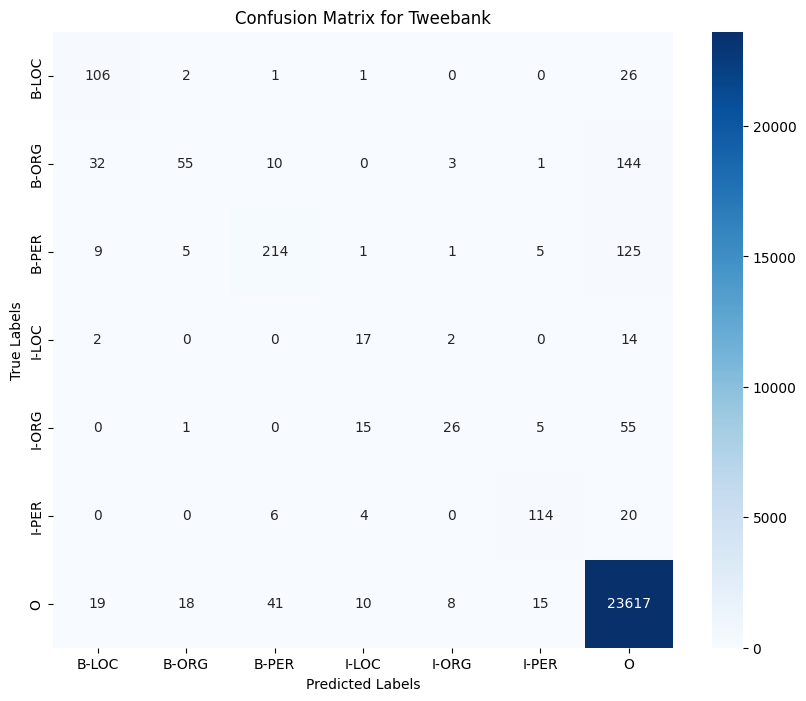

In [63]:
# For TweeBank

# Flatten the true_predictions and true_labels lists
true_predictions_flat = [label for sublist in true_predictions_twee for label in sublist]
true_labels_flat = [label for sublist in true_labels_twee for label in sublist]
print(true_predictions_flat)
print(true_labels_flat)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels_flat, true_predictions_flat)
# Get the unique labels
unique_labels = sorted(set(true_labels_flat))


# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Tweebank')

Text(0.5, 1.0, 'Confusion Matrix for CrossNER')

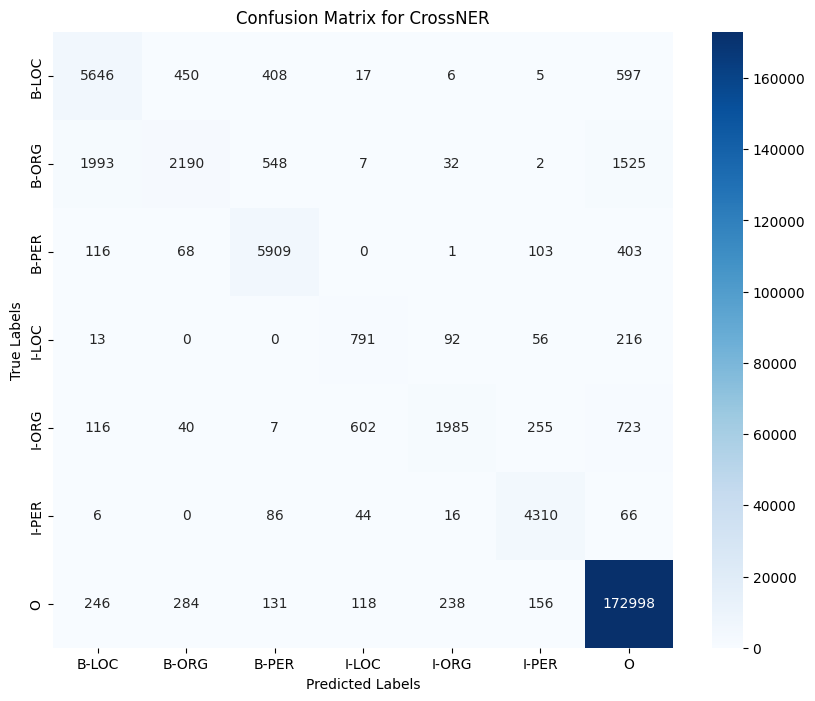

In [64]:
# For Cross NER


# Flatten the true_predictions and true_labels lists
true_predictions_flat_crossNER = [label for sublist in true_predictions_crossNER for label in sublist]
true_labels_flat_crossNER = [label for sublist in true_labels_crossNER for label in sublist]


# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels_flat_crossNER, true_predictions_flat_crossNER)
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for CrossNER')

Text(0.5, 1.0, 'Confusion Matrix for EWT_dev')

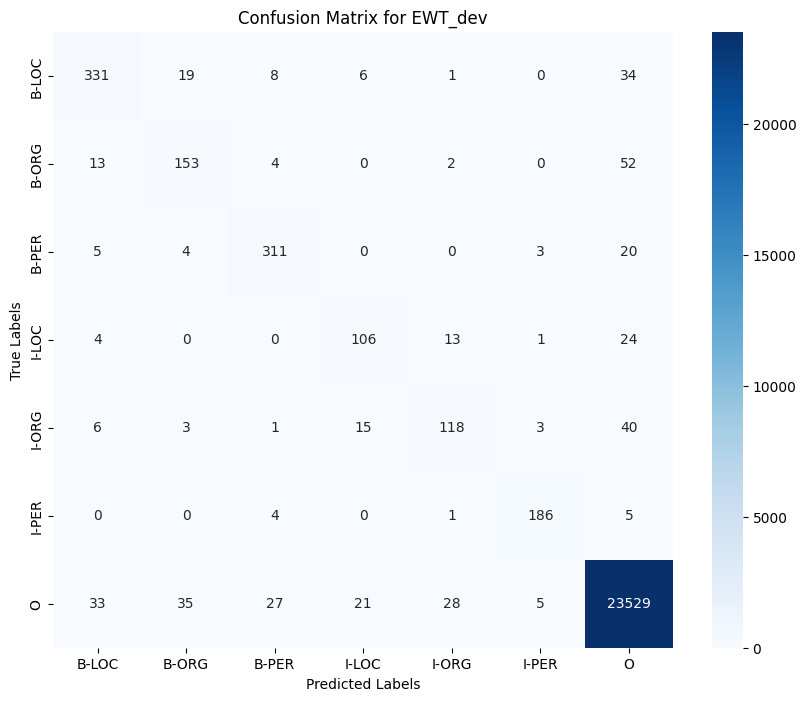

In [68]:
# for EWT DEV

# Flatten the true_predictions and true_labels lists
true_predictions_flat_dev = [label for sublist in true_predictions_dev for label in sublist]
true_labels_flat_dev = [label for sublist in true_labels_dev for label in sublist]


# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels_flat_dev, true_predictions_flat_dev)
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for EWT_dev')